<a href="https://colab.research.google.com/github/sameera-g-mathad/DSC-478/blob/main/DSC_478_Final_Project(Book_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'books-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F912577%2F1546766%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240328%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240328T000246Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7c08497a3c1ccc8bbecf8bdc9ac890c55efdf77fe487f0ec5885cb1fe522803a56051de7358c23a7f2568a7ae8aad059cc34eddbd821810903a40206a9c30f29a3e08bbcfe46d6ae8a0d8b4f242c99ede7e1ce117ab3f149c64098aaf73dc9aacbfb3ab59726fc9d208ceb63f0ae3ea0470551d591295d8c02804b8543b3484426e3a43673d14fbe86a078e96e68b0887dbda5c1c213e0b73ba463f25c6693b25b57195dc504dce05273737c916edbf120f272371ae764fcb8714e5796ff560f972b9417f19bc2d6d091b8ffda34e6ecfdf454684b56f1612cc7759870b22538191555a9259274cea5874a754c0fa762025c9189668426af573b380247c43ae4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 25760320 bytes downloaded
Downloaded and uncompressed: books-dataset
Data source import complete.


In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import NearestCentroid,NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.utils.extmath import randomized_svd
from IPython.display import display
from numpy import linalg as la
from scipy.sparse import csr_matrix
pd.set_option('display.max_colwidth',None)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/books-dataset/books_data/books.csv
/kaggle/input/books-dataset/books_data/users.csv
/kaggle/input/books-dataset/books_data/ratings.csv


# ------------ Pre-Processing ------------

#### Loading all the Data files

In [89]:
users_df = pd.read_csv('/kaggle/input/books-dataset/books_data/users.csv',sep=";",on_bad_lines="skip",encoding='latin-1')
ratings_df = pd.read_csv('/kaggle/input/books-dataset/books_data/ratings.csv',sep=";",on_bad_lines="skip",encoding='latin-1')
books_df = pd.read_csv("/kaggle/input/books-dataset/books_data/books.csv",sep=";",on_bad_lines='skip',encoding = 'latin-1',low_memory = False)

#### List down all the loaded files to check the shape and data

In [90]:
print("Books dataframe shape: " , books_df.shape)
print("Ratings dataframe shape: " , ratings_df.shape)
print("Users dataframe shape: " , users_df.shape)

Books dataframe shape:  (271360, 8)
Ratings dataframe shape:  (1149780, 3)
Users dataframe shape:  (278858, 3)


In [91]:
books_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [92]:
ratings_df.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [93]:
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### *********************** PRE-PROCESSING ****************************

#### First we will work on users dataframe

In [94]:
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


#### From the above result, we can see that location consists of city, state, country
#### So, we will filter out the attribute having data less than 3 values

In [95]:
# Getting the indices of location which is not equal to 3
drop_indeces = users_df[users_df['Location'].str.split(",").str.len() != 3].index

In [96]:
## Dropping the above indices
users_df = users_df.drop(index = drop_indeces)


In [97]:
## Computing the count whose location has all 3 values
(users_df['Location'].str.split(",").str.len()==3).value_counts()

True    277348
Name: Location, dtype: int64

#### Splitting location column into City,State and Country columns

In [98]:
users_df[['City','State','Country']] = users_df['Location'].str.strip().str.split(",",expand = True,n=2)

#### Trimming data to removing leading and tailing spaces

In [99]:
users_df['City'] = users_df['City'].str.strip()
users_df['State'] = users_df['State'].str.strip()
users_df['Country'] = users_df['Country'].str.strip()

In [100]:
users_df.head()

,User-ID,Location,Age,City,State,Country
0,1,"nyc, new york, usa",NaN,nyc,new york,usa
1,2,"stockton, california, usa",18.0,stockton,california,usa
2,3,"moscow, yukon territory, russia",NaN,moscow,yukon territory,russia
3,4,"porto, v.n.gaia, portugal",17.0,porto,v.n.gaia,portugal
4,5,"farnborough, hants, united kingdom",NaN,farnborough,hants,united kingdom


#### from the above result, we can see that location's data is split into city state and country

#### Dropping column 'Location' as it is split into (City,State,Country) columns

In [101]:
users_df = users_df.drop('Location',axis = 1)
users_df

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,NaN,portland,oregon,usa
278854,278855,50.0,tacoma,washington,united kingdom
278855,278856,NaN,brampton,ontario,canada
278856,278857,NaN,knoxville,tennessee,usa


In [102]:
users_df['Age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,   2.,  70.,  77.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

#### From the above result we can see that there are values of age greater than 100 which is not ideal so filtering it out

## Also we are considering age group between 10 to 90 to get more appropriate data

In [103]:
users_df[~users_df['Age'].between(10,90) & ~users_df['Age'].isnull()]['Age'].unique()

array([  0.,   1.,   9., 103., 104., 231.,   3., 119.,   2.,  93.,   8.,
         7.,   4., 114., 230., 239.,   5., 148., 151.,   6., 101., 201.,
        96., 123., 244., 133.,  91., 128.,  94., 141., 110.,  97., 219.,
       124.,  92., 175., 172., 209., 212., 237., 162., 100., 156., 136.,
        95., 106.,  99., 108., 210., 199., 147., 168., 132., 159., 186.,
       152., 102., 116., 200., 115., 226., 137., 207., 229., 138., 109.,
       105., 228., 183., 204.,  98., 223., 113., 208., 157., 111., 146.,
       118., 220., 143., 140., 189., 127.])

Text(0, 0.5, 'Frequency')

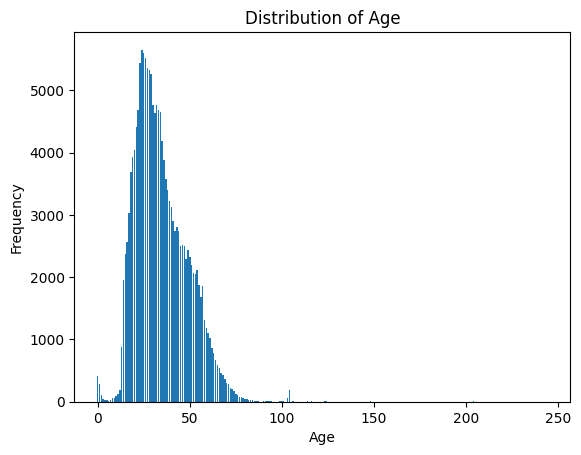

In [104]:
ages_graph_params = users_df.groupby('Age').size()
plt.bar(ages_graph_params.index,ages_graph_params.values)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

#### Filtering the age group as mentioned

In [105]:
users_to_omit = ~users_df['Age'].between(10,90) & ~users_df['Age'].isnull()
users_df.loc[users_to_omit] = np.nan
users_df['Age'].sort_values().unique()

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
       62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74.,
       75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 87.,
       88., 89., 90., nan])

#### From the above result, now we can see that age is as expected. Now we can replace the Nan values with its mean

In [106]:
users_df.head()

,User-ID,Age,City,State,Country
0,1.0,NaN,nyc,new york,usa
1,2.0,18.0,stockton,california,usa
2,3.0,NaN,moscow,yukon territory,russia
3,4.0,17.0,porto,v.n.gaia,portugal
4,5.0,NaN,farnborough,hants,united kingdom


In [107]:
users_df['Age'].mean()

34.729518290474466

#### Imputing age column with the mean age value of 34

In [108]:
null_age = users_df['Age'].isnull()
users_df.loc[null_age,'Age'] = users_df['Age'].mean()

<BarContainer object of 82 artists>

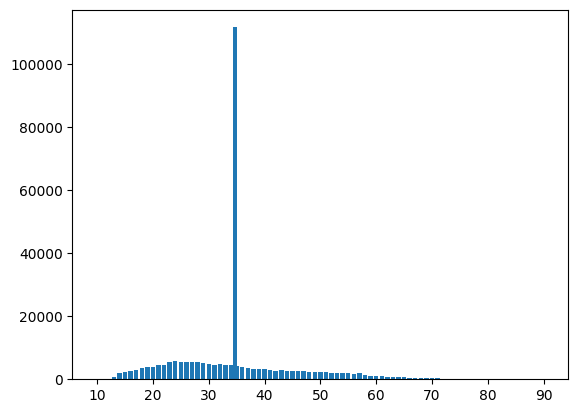

In [109]:
ages_graph_params = users_df.groupby('Age').size()
plt.bar(ages_graph_params.index,ages_graph_params.values)


In [110]:
users_df.head()

,User-ID,Age,City,State,Country
0,1.0,34.729518,nyc,new york,usa
1,2.0,18.000000,stockton,california,usa
2,3.0,34.729518,moscow,yukon territory,russia
3,4.0,17.000000,porto,v.n.gaia,portugal
4,5.0,34.729518,farnborough,hants,united kingdom


In [111]:
users_df['Age'] = users_df['Age'].astype('int')

In [112]:
users_df['Age'].sort_values().unique()

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])

#### From the above result now we can say that age attribute is pre-processed correctly

#### Column country has garbage and reduntant values

In [113]:
users_df['Country'].sort_values().unique()

array(['', '"', '&#20013;&#22269;', '&#32654;&#22269;', '*', '-',
       '-------', '.', '01776', '02458', '19104', '23232', '30064',
       '5057chadwick ct.', '85021', '87510', '?ú?{', '\\"n/a\\""',
       '\\n/a\\""', '_ brasil', 'a', 'aaa', 'adsgfdr',
       'afganstand holla !!', 'afghanistan', 'ahrensburg', 'alachua',
       'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra',
       'america', 'american samoa', 'andorra', 'andorra"', 'angola',
       'antarctica', 'antigua & barbuda', 'antigua and barbuda',
       'aotearoa', 'argentina', 'argentina"', 'armenia', 'aroostook',
       'aruba', 'asturies', 'auckland', 'australia', 'australia"',
       'australii', 'austria', 'austria"', 'autralia', 'az', 'azerbaijan',
       'bademn würtemberg', 'baden-württemberg', 'bahamas', 'bahrain',
       'baltimore', 'bangladesh', 'bangladesh"', 'barbados', 'basilicata',
       'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus',
       'belgi', 'belgique', 'belgium', 

#### We are using list of countries from this link for filtering out users.

In [114]:
countries = (
    ('AF', 'AFGHANISTAN'),
    ('AL', 'ALBANIA'),
    ('DZ', 'ALGERIA'),
    ('AS', 'AMERICAN SAMOA'),
    ('AD', 'ANDORRA'),
    ('AO', 'ANGOLA'),
    ('AI', 'ANGUILLA'),
    ('AQ', 'ANTARCTICA'),
    ('AG', 'ANTIGUA AND BARBUDA'),
    ('AR', 'ARGENTINA'),
    ('AM', 'ARMENIA'),
    ('AW', 'ARUBA'),
    ('AU', 'AUSTRALIA'),
    ('AT', 'AUSTRIA'),
    ('AZ', 'AZERBAIJAN'),
    ('BS', 'BAHAMAS'),
    ('BH', 'BAHRAIN'),
    ('BD', 'BANGLADESH'),
    ('BB', 'BARBADOS'),
    ('BY', 'BELARUS'),
    ('BE', 'BELGIUM'),
    ('BZ', 'BELIZE'),
    ('BJ', 'BENIN'),
    ('BM', 'BERMUDA'),
    ('BT', 'BHUTAN'),
    ('BO', 'BOLIVIA'),
    ('BA', 'BOSNIA AND HERZEGOVINA'),
    ('BW', 'BOTSWANA'),
    ('BV', 'BOUVET ISLAND'),
    ('BR', 'BRAZIL'),
    ('IO', 'BRITISH INDIAN OCEAN TERRITORY'),
    ('BN', 'BRUNEI DARUSSALAM'),
    ('BG', 'BULGARIA'),
    ('BF', 'BURKINA FASO'),
    ('BI', 'BURUNDI'),
    ('KH', 'CAMBODIA'),
    ('CM', 'CAMEROON'),
    ('CA', 'CANADA'),
    ('CV', 'CAPE VERDE'),
    ('KY', 'CAYMAN ISLANDS'),
    ('CF', 'CENTRAL AFRICAN REPUBLIC'),
    ('TD', 'CHAD'),
    ('CL', 'CHILE'),
    ('CN', 'CHINA'),
    ('CX', 'CHRISTMAS ISLAND'),
    ('CC', 'COCOS (KEELING) ISLANDS'),
    ('CO', 'COLOMBIA'),
    ('KM', 'COMOROS'),
    ('CG', 'CONGO'),
    ('CD', 'CONGO, THE DEMOCRATIC REPUBLIC OF'),
    ('CK', 'COOK ISLANDS'),
    ('CR', 'COSTA RICA'),
    ('CI', "CÃ”TE D'IVOIRE"),
    ('HR', 'CROATIA'),
    ('CU', 'CUBA'),
    ('CY', 'CYPRUS'),
    ('CZ', 'CZECH REPUBLIC'),
    ('DK', 'DENMARK'),
    ('DJ', 'DJIBOUTI'),
    ('DM', 'DOMINICA'),
    ('DO', 'DOMINICAN REPUBLIC'),
    ('EC', 'ECUADOR'),
    ('EG', 'EGYPT'),
    ('SV', 'EL SALVADOR'),
    ('GQ', 'EQUATORIAL GUINEA'),
    ('ER', 'ERITREA'),
    ('EE', 'ESTONIA'),
    ('ET', 'ETHIOPIA'),
    ('FK', 'FALKLAND ISLANDS (MALVINAS)'),
    ('FO', 'FAROE ISLANDS'),
    ('FJ', 'FIJI'),
    ('FI', 'FINLAND'),
    ('FR', 'FRANCE'),
    ('GF', 'FRENCH GUIANA'),
    ('PF', 'FRENCH POLYNESIA'),
    ('TF', 'FRENCH SOUTHERN TERRITORIES'),
    ('GA', 'GABON'),
    ('GM', 'GAMBIA'),
    ('GE', 'GEORGIA'),
    ('DE', 'GERMANY'),
    ('GH', 'GHANA'),
    ('GI', 'GIBRALTAR'),
    ('GR', 'GREECE'),
    ('GL', 'GREENLAND'),
    ('GD', 'GRENADA'),
    ('GP', 'GUADELOUPE'),
    ('GU', 'GUAM'),
    ('GT', 'GUATEMALA'),
    ('GN', 'GUINEA'),
    ('GW', 'GUINEA'),
    ('GY', 'GUYANA'),
    ('HT', 'HAITI'),
    ('HM', 'HEARD ISLAND AND MCDONALD ISLANDS'),
    ('HN', 'HONDURAS'),
    ('HK', 'HONG KONG'),
    ('HU', 'HUNGARY'),
    ('IS', 'ICELAND'),
    ('IN', 'INDIA'),
    ('ID', 'INDONESIA'),
    ('IR', 'IRAN, ISLAMIC REPUBLIC OF'),
    ('IQ', 'IRAQ'),
    ('IE', 'IRELAND'),
    ('IL', 'ISRAEL'),
    ('IT', 'ITALY'),
    ('JM', 'JAMAICA'),
    ('JP', 'JAPAN'),
    ('JO', 'JORDAN'),
    ('KZ', 'KAZAKHSTAN'),
    ('KE', 'KENYA'),
    ('KI', 'KIRIBATI'),
    ('KP', "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF"),
    ('KR', 'KOREA, REPUBLIC OF'),
    ('KW', 'KUWAIT'),
    ('KG', 'KYRGYZSTAN'),
    ('LA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC"),
    ('LV', 'LATVIA'),
    ('LB', 'LEBANON'),
    ('LS', 'LESOTHO'),
    ('LR', 'LIBERIA'),
    ('LY', 'LIBYAN ARAB JAMAHIRIYA'),
    ('LI', 'LIECHTENSTEIN'),
    ('LT', 'LITHUANIA'),
    ('LU', 'LUXEMBOURG'),
    ('MO', 'MACAO'),
    ('MK', 'MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF'),
    ('MG', 'MADAGASCAR'),
    ('MW', 'MALAWI'),
    ('MY', 'MALAYSIA'),
    ('MV', 'MALDIVES'),
    ('ML', 'MALI'),
    ('MT', 'MALTA'),
    ('MH', 'MARSHALL ISLANDS'),
    ('MQ', 'MARTINIQUE'),
    ('MR', 'MAURITANIA'),
    ('MU', 'MAURITIUS'),
    ('YT', 'MAYOTTE'),
    ('MX', 'MEXICO'),
    ('FM', 'MICRONESIA, FEDERATED STATES OF'),
    ('MD', 'MOLDOVA, REPUBLIC OF'),
    ('MC', 'MONACO'),
    ('MN', 'MONGOLIA'),
    ('MS', 'MONTSERRAT'),
    ('MA', 'MOROCCO'),
    ('MZ', 'MOZAMBIQUE'),
    ('MM', 'MYANMAR'),
    ('NA', 'NAMIBIA'),
    ('NR', 'NAURU'),
    ('NP', 'NEPAL'),
    ('NL', 'NETHERLANDS'),
    ('AN', 'NETHERLANDS ANTILLES'),
    ('NC', 'NEW CALEDONIA'),
    ('NZ', 'NEW ZEALAND'),
    ('NI', 'NICARAGUA'),
    ('NE', 'NIGER'),
    ('NG', 'NIGERIA'),
    ('NU', 'NIUE'),
    ('NF', 'NORFOLK ISLAND'),
    ('MP', 'NORTHERN MARIANA ISLANDS'),
    ('NO', 'NORWAY'),
    ('OM', 'OMAN'),
    ('PK', 'PAKISTAN'),
    ('PW', 'PALAU'),
    ('PS', 'PALESTINIAN TERRITORY, OCCUPIED'),
    ('PA', 'PANAMA'),
    ('PG', 'PAPUA NEW GUINEA'),
    ('PY', 'PARAGUAY'),
    ('PE', 'PERU'),
    ('PH', 'PHILIPPINES'),
    ('PN', 'PITCAIRN'),
    ('PL', 'POLAND'),
    ('PT', 'PORTUGAL'),
    ('PR', 'PUERTO RICO'),
    ('QA', 'QATAR'),
    ('RE', 'RÃ‰UNION'),
    ('RO', 'ROMANIA'),
    ('RU', 'RUSSIAN FEDERATION'),
    ('RW', 'RWANDA'),
    ('SH', 'SAINT HELENA'),
    ('KN', 'SAINT KITTS AND NEVIS'),
    ('LC', 'SAINT LUCIA'),
    ('PM', 'SAINT PIERRE AND MIQUELON'),
    ('VC', 'SAINT VINCENT AND THE GRENADINES'),
    ('WS', 'SAMOA'),
    ('SM', 'SAN MARINO'),
    ('ST', 'SAO TOME AND PRINCIPE'),
    ('SA', 'SAUDI ARABIA'),
    ('SN', 'SENEGAL'),
    ('CS', 'SERBIA AND MONTENEGRO'),
    ('SC', 'SEYCHELLES'),
    ('SL', 'SIERRA LEONE'),
    ('SG', 'SINGAPORE'),
    ('SK', 'SLOVAKIA'),
    ('SI', 'SLOVENIA'),
    ('SB', 'SOLOMON ISLANDS'),
    ('SO', 'SOMALIA'),
    ('ZA', 'SOUTH AFRICA'),
    ('GS', 'SOUTH GEORGIA AND SOUTH SANDWICH ISLANDS'),
    ('ES', 'SPAIN'),
    ('LK', 'SRI LANKA'),
    ('SD', 'SUDAN'),
    ('SR', 'SURINAME'),
    ('SJ', 'SVALBARD AND JAN MAYEN'),
    ('SZ', 'SWAZILAND'),
    ('SE', 'SWEDEN'),
    ('CH', 'SWITZERLAND'),
    ('SY', 'SYRIAN ARAB REPUBLIC'),
    ('TW', 'TAIWAN, PROVINCE OF CHINA'),
    ('TJ', 'TAJIKISTAN'),
    ('TZ', 'TANZANIA, UNITED REPUBLIC OF'),
    ('TH', 'THAILAND'),
    ('TL', 'TIMOR'),
    ('TG', 'TOGO'),
    ('TK', 'TOKELAU'),
    ('TO', 'TONGA'),
    ('TT', 'TRINIDAD AND TOBAGO'),
    ('TN', 'TUNISIA'),
    ('TR', 'TURKEY'),
    ('TM', 'TURKMENISTAN'),
    ('TC', 'TURKS AND CAICOS ISLANDS'),
    ('TV', 'TUVALU'),
    ('UG', 'UGANDA'),
    ('UA', 'UKRAINE'),
    ('AE', 'UNITED ARAB EMIRATES'),
    ('GB', 'UNITED KINGDOM'),
    ('US', 'UNITED STATES'),
    ('UM', 'UNITED STATES MINOR OUTLYING ISLANDS'),
    ('UY', 'URUGUAY'),
    ('UZ', 'UZBEKISTAN'),
    ('VU', 'VANUATU'),
    ('VN', 'VIET NAM'),
    ('VG', 'VIRGIN ISLANDS, BRITISH'),
    ('VI', 'VIRGIN ISLANDS, U.S.'),
    ('WF', 'WALLIS AND FUTUNA'),
    ('EH', 'WESTERN SAHARA'),
    ('YE', 'YEMEN'),
    ('ZW', 'ZIMBABWE')
)

In [115]:
list_of_countries = []
for i in countries:
    list_of_countries.append(i[1].lower())

In [116]:
print(list_of_countries)

['afghanistan', 'albania', 'algeria', 'american samoa', 'andorra', 'angola', 'anguilla', 'antarctica', 'antigua and barbuda', 'argentina', 'armenia', 'aruba', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bermuda', 'bhutan', 'bolivia', 'bosnia and herzegovina', 'botswana', 'bouvet island', 'brazil', 'british indian ocean territory', 'brunei darussalam', 'bulgaria', 'burkina faso', 'burundi', 'cambodia', 'cameroon', 'canada', 'cape verde', 'cayman islands', 'central african republic', 'chad', 'chile', 'china', 'christmas island', 'cocos (keeling) islands', 'colombia', 'comoros', 'congo', 'congo, the democratic republic of', 'cook islands', 'costa rica', "cã”te d'ivoire", 'croatia', 'cuba', 'cyprus', 'czech republic', 'denmark', 'djibouti', 'dominica', 'dominican republic', 'ecuador', 'egypt', 'el salvador', 'equatorial guinea', 'eritrea', 'estonia', 'ethiopia', 'falkland islands (malvinas)', 'faroe islands

#### Filtering users based on our list_of_countries values

In [117]:
users_df = users_df[users_df['Country'].isin(list_of_countries)]
users_df

,User-ID,Age,City,State,Country
3,4.0,17,porto,v.n.gaia,portugal
4,5.0,34,farnborough,hants,united kingdom
7,8.0,34,timmins,ontario,canada
9,10.0,26,albacete,wisconsin,spain
10,11.0,14,melbourne,victoria,australia
...,...,...,...,...,...
278851,278852.0,32,brisbane,queensland,australia
278852,278853.0,17,stranraer,n/a,united kingdom
278854,278855.0,50,tacoma,washington,united kingdom
278855,278856.0,34,brampton,ontario,canada


#### Now selecting states and cities with atleast 4 characters and filtering it out with junk characters

In [118]:
list_of_states = users_df['State'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()

In [119]:
users_df = users_df[users_df['State'].isin(list_of_states)]

In [120]:
list_of_city = users_df['City'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()
users_df = users_df[users_df['City'].isin(list_of_city)]

In [121]:
print("Unique country count: " , users_df['Country'].nunique())
print("Unique state count: " ,users_df['State'].nunique())
print("Unique City count: " , users_df['City'].nunique())

Unique country count:  154
Unique state count:  2192
Unique City count:  8452


#### Filtering the books dataset. Removing unrelated attributes

In [122]:
books_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [123]:
books_df = books_df.drop(['Image-URL-S','Image-URL-M','Image-URL-L'],axis = 1)
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [124]:
books_df['Year-Of-Publication'].unique()


array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

#### From the above result, we can see some garbage values in 'Year-Of-Publication' instead of only year values, which will be filtered and the column is converted into int

In [125]:
year_of_publication = books_df['Year-Of-Publication'].str.extract(r'(\d{4})')[0]
books_df = books_df[books_df['Year-Of-Publication'].isin(year_of_publication)]

In [126]:
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype('int')

<ipython-input-126-4e2bf0d627c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype('int')


In [127]:
books_df['Year-Of-Publication'].unique()


array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911,
       1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910,
       1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010,
       1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378, 1919,
       1922, 1897, 2024, 1376, 2037])

#### Lets Check Ratings Datafram

In [128]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [129]:
sorted(ratings_df['Book-Rating'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Text(0, 0.5, 'Frequency')

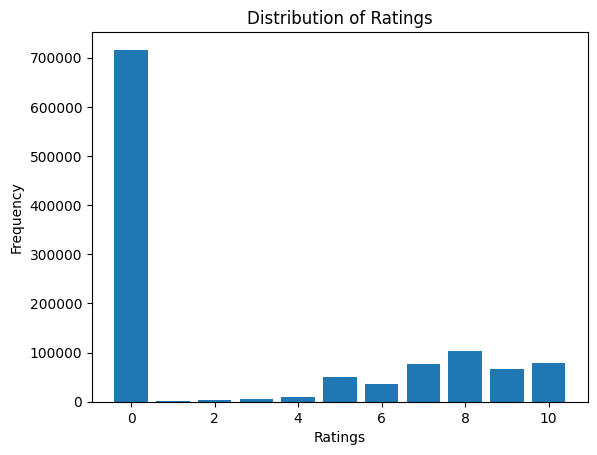

In [130]:
ratings_group = ratings_df.groupby('Book-Rating').size()
plt.bar(ratings_group.index,ratings_group.values)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

#### Lets check the info of all 3 data files

In [131]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [132]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266739 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 266739 non-null  object
 1   Book-Title           266739 non-null  object
 2   Book-Author          266738 non-null  object
 3   Year-Of-Publication  266739 non-null  int64 
 4   Publisher            266737 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.2+ MB


In [133]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69301 entries, 4 to 278855
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User-ID  69301 non-null  float64
 1   Age      69301 non-null  int64  
 2   City     69301 non-null  object 
 3   State    69301 non-null  object 
 4   Country  69301 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 3.2+ MB


#### Now preparing the dataset for further implementation

#### Merging Users,Books,Ratings dataframe for our dataset

In [134]:
dataset = ratings_df.merge(books_df,on = 'ISBN').merge(users_df,how='inner',on='User-ID')
dataset.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 132920 entries, 0 to 132919
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User-ID              132920 non-null  int64 
 1   ISBN                 132920 non-null  object
 2   Book-Rating          132920 non-null  int64 
 3   Book-Title           132920 non-null  object
 4   Book-Author          132919 non-null  object
 5   Year-Of-Publication  132920 non-null  int64 
 6   Publisher            132920 non-null  object
 7   Age                  132920 non-null  int64 
 8   City                 132920 non-null  object
 9   State                132920 non-null  object
 10  Country              132920 non-null  object
dtypes: int64(4), object(7)
memory usage: 12.2+ MB


#### Dropping the duplicate user-ID and ISBN rows as a user can have only one rating per book.

In [135]:
dataset = dataset.drop_duplicates(['User-ID','ISBN'],keep='first')
dataset.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,77940,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,34,melaka,melaka,malaysia
1,77940,0671793489,0,All Around the Town,Mary Higgins Clark,1993,Pocket Star,34,melaka,melaka,malaysia
2,77940,0553586122,0,Reap the Wind,Iris Johansen,2002,Bantam Books,34,melaka,melaka,malaysia
3,77940,055358068X,0,The Least Likely Bride,Jane Feather,2000,Bantam,34,melaka,melaka,malaysia
4,77940,0743422732,0,High Country Bride (McKettrick Cowboys),Linda Lael Miller,2002,Pocket,34,melaka,melaka,malaysia


In [136]:
dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].sample(10)

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
77784,3,Philipp Zabern,2003,American University in Cairo Press,30,dublin,leinster,ireland
93215,5,Douglas Coupland,1992,St. Martin's Press,27,oeiras,lisboa,portugal
108343,0,Sir Arthur Conan Doyle,1998,NTC/Contemporary Publishing Company,34,aberdeen,scotland,united kingdom
11833,0,Philip K. Dick,1987,Harper Mass Market Paperbacks (Mm),34,edmonton,alberta,canada
111533,0,Kathryn Koob,1982,T. Nelson Pub,34,calgary,alberta,canada
132084,0,Douglas Arnold,2003,Publishamerica,49,plymouth,england,united kingdom
27098,0,Barbara Kingsolver,1998,HarperTorch,33,newmarket,ontario,canada
118823,4,Stephen Baxter,2002,Del Rey Books,34,cobourg,ontario,canada
5399,0,Jan Freed,1998,Harlequin,29,calgary,alberta,canada
92257,0,Daniel Cohen,1986,Pocket Books,34,ottawa,ontario,canada


#### Selecting the required columns for training

In [137]:
recomendation_dataset = dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].copy()
recomendation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132920 entries, 0 to 132919
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Book-Rating          132920 non-null  int64 
 1   Book-Author          132919 non-null  object
 2   Year-Of-Publication  132920 non-null  int64 
 3   Publisher            132920 non-null  object
 4   Age                  132920 non-null  int64 
 5   City                 132920 non-null  object
 6   State                132920 non-null  object
 7   Country              132920 non-null  object
dtypes: int64(3), object(5)
memory usage: 9.1+ MB


#### Label encoding all catecorical columns

In [138]:
encoder = LabelEncoder()
for column in recomendation_dataset.columns:
    if recomendation_dataset[column].dtype == object:
        recomendation_dataset[column] = encoder.fit_transform(recomendation_dataset[column])


In [139]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0,19612,2002,509,34,1645,405,50
1,0,21072,1993,4719,34,1645,405,50
2,0,12763,2002,521,34,1645,405,50
3,0,13844,2000,519,34,1645,405,50
4,0,18838,2002,4712,34,1645,405,50
...,...,...,...,...,...,...,...,...
132915,0,12627,2003,1889,24,2885,15,76
132916,0,14219,2001,2420,50,2909,757,79
132917,6,16965,2004,6340,41,59,496,16
132918,0,29771,2000,231,27,2675,706,6


#### Normalizing every column to range between 0 and 1

In [140]:
def normalizer(data,min,max):
    return (data - min) / (max - min)

In [141]:
for column in recomendation_dataset.columns:
    min = recomendation_dataset[column].min()
    max = recomendation_dataset[column].max()
    recomendation_dataset[column] = recomendation_dataset[column].apply(normalizer,args=(min,max))


In [142]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0.0,0.603799,0.675676,0.076118,0.3000,0.565486,0.535007,0.549451
1,0.0,0.648748,0.614865,0.705698,0.3000,0.565486,0.535007,0.549451
2,0.0,0.392937,0.675676,0.077912,0.3000,0.565486,0.535007,0.549451
3,0.0,0.426218,0.662162,0.077613,0.3000,0.565486,0.535007,0.549451
4,0.0,0.579970,0.675676,0.704651,0.3000,0.565486,0.535007,0.549451
...,...,...,...,...,...,...,...,...
132915,0.0,0.388750,0.682432,0.282488,0.1750,0.991750,0.019815,0.835165
132916,0.0,0.437764,0.668919,0.361896,0.5000,1.000000,1.000000,0.868132
132917,0.6,0.522305,0.689189,0.948108,0.3875,0.020282,0.655218,0.175824
132918,0.0,0.916567,0.662162,0.034545,0.2125,0.919560,0.932629,0.065934


#### KMeans

#### Running KMeans for finding better k value for clustering

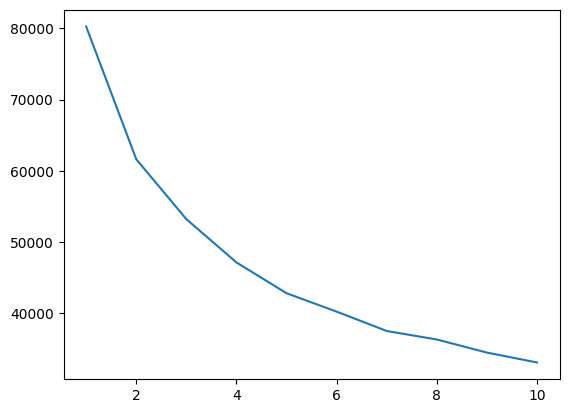

In [143]:
inertias = []
for i in range(1,11):
    km = KMeans(n_clusters = i,n_init = 'auto')
    km.fit(recomendation_dataset)
    inertias.append(km.inertia_)
plt.plot(range(1,11),inertias)


#### Training on the k value from the above elbow method

In [144]:
kmeans = KMeans(n_clusters= 5,n_init = 'auto')
clusters = kmeans.fit_predict(recomendation_dataset)


#### Appending cluster values back to our training dataset

In [145]:
recomendation_dataset['Clusters'] = clusters

In [146]:
recomendation_dataset['Clusters'].value_counts()

1    35895
3    26474
0    26239
2    26009
4    18303
Name: Clusters, dtype: int64

In [147]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
0,0.0,0.603799,0.675676,0.076118,0.3000,0.565486,0.535007,0.549451,3
1,0.0,0.648748,0.614865,0.705698,0.3000,0.565486,0.535007,0.549451,3
2,0.0,0.392937,0.675676,0.077912,0.3000,0.565486,0.535007,0.549451,3
3,0.0,0.426218,0.662162,0.077613,0.3000,0.565486,0.535007,0.549451,3
4,0.0,0.579970,0.675676,0.704651,0.3000,0.565486,0.535007,0.549451,3
...,...,...,...,...,...,...,...,...,...
132915,0.0,0.388750,0.682432,0.282488,0.1750,0.991750,0.019815,0.835165,3
132916,0.0,0.437764,0.668919,0.361896,0.5000,1.000000,1.000000,0.868132,3
132917,0.6,0.522305,0.689189,0.948108,0.3875,0.020282,0.655218,0.175824,2
132918,0.0,0.916567,0.662162,0.034545,0.2125,0.919560,0.932629,0.065934,1


#### Selecting training and test data

In [148]:
train_df,test_df = recomendation_dataset.iloc[:,:-1],recomendation_dataset.iloc[:,-1]

#### Splitting training and testing dataset

In [149]:
train_X,test_x,train_y,test_y = train_test_split(train_df,test_df,test_size=0.2)

#### ROCCHIO CLASSIFIER

#### Creating an instance of Rocchio classifier

In [150]:
rocchio_clf = NearestCentroid()
rocchio_clf.fit(train_X,train_y)

NearestCentroid()

#### Checking the correctness and accuracy of rocchio method using cross validation

In [151]:
print(cross_val_score(rocchio_clf,train_df,test_df,cv = 5))

[0.9990972  0.99924767 0.9981944  0.99623834 0.99732922]


#### Predicting results

In [152]:
pred_y = rocchio_clf.predict(test_x)

In [153]:
accuracy_score(test_y,pred_y) * 100

99.9586217273548

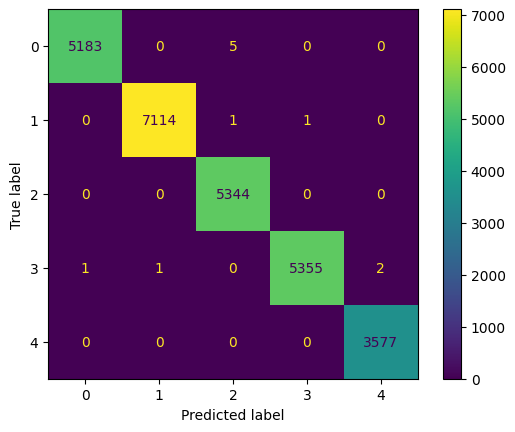

In [154]:
cm = confusion_matrix(test_y,pred_y)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

#### Taking some samples for recomendation

In [155]:
samples = test_x.sample(10)
samples

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
125195,0.0,0.477017,0.675676,0.896516,0.3000,0.398075,0.261559,0.956044
33592,0.0,0.632462,0.648649,0.770899,0.1250,0.543486,0.713342,0.747253
14233,0.0,0.998122,0.675676,0.694033,0.3000,0.919560,0.932629,0.065934
74613,0.0,0.755673,0.641892,0.394497,0.4750,0.377449,0.655218,0.175824
130057,0.0,0.948555,0.587838,0.663676,0.3625,0.295978,0.931308,0.054945
82049,0.7,0.185493,0.675676,0.348437,0.3000,0.596081,0.731836,0.175824
13828,0.8,0.484837,0.662162,0.726484,0.2375,0.673084,0.655218,0.175824
107333,0.5,0.149287,0.662162,0.317183,0.3250,0.673084,0.655218,0.175824
67638,0.5,0.048644,0.614865,0.397189,0.3000,0.525610,0.261559,0.956044
121164,0.5,0.754964,0.635135,0.290564,0.5250,0.127535,0.261559,0.956044


In [156]:
indeces = samples.index.tolist()
indeces

[125195, 33592, 14233, 74613, 130057, 82049, 13828, 107333, 67638, 121164]

#### Predicting cluster values for our sample values

In [157]:
samples_pred = rocchio_clf.predict(samples).reshape(1,-1).flatten().tolist()
samples_pred

[3, 3, 1, 1, 1, 2, 2, 2, 0, 0]

In [158]:
data = train_X.copy()

In [159]:
data['Clusters'] = train_y

In [160]:
data

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
75421,1.0,0.895200,0.662162,0.156572,0.3000,0.987625,0.261559,0.956044,0
99269,0.0,0.398633,0.668919,0.794527,0.2750,0.156755,0.700132,0.461538,4
59448,0.7,0.575660,0.689189,0.183042,0.1500,0.497078,0.261559,0.956044,0
91697,1.0,0.405037,0.648649,0.743682,0.4625,0.666552,0.655218,0.175824,2
124976,0.6,0.558296,0.641892,0.704651,0.2250,0.155036,0.019815,0.175824,4
...,...,...,...,...,...,...,...,...,...
120559,0.0,0.335766,0.554054,0.704202,0.0500,0.406325,0.865258,0.054945,1
71794,0.0,0.752686,0.662162,0.238223,0.6000,0.381231,0.602378,0.351648,1
84771,0.0,0.750777,0.581081,0.078062,0.5000,0.191475,0.170410,0.626374,4
92322,0.8,0.340230,0.621622,0.360849,0.3000,0.874871,0.655218,0.175824,2


In [161]:
samples

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
125195,0.0,0.477017,0.675676,0.896516,0.3000,0.398075,0.261559,0.956044
33592,0.0,0.632462,0.648649,0.770899,0.1250,0.543486,0.713342,0.747253
14233,0.0,0.998122,0.675676,0.694033,0.3000,0.919560,0.932629,0.065934
74613,0.0,0.755673,0.641892,0.394497,0.4750,0.377449,0.655218,0.175824
130057,0.0,0.948555,0.587838,0.663676,0.3625,0.295978,0.931308,0.054945
82049,0.7,0.185493,0.675676,0.348437,0.3000,0.596081,0.731836,0.175824
13828,0.8,0.484837,0.662162,0.726484,0.2375,0.673084,0.655218,0.175824
107333,0.5,0.149287,0.662162,0.317183,0.3250,0.673084,0.655218,0.175824
67638,0.5,0.048644,0.614865,0.397189,0.3000,0.525610,0.261559,0.956044
121164,0.5,0.754964,0.635135,0.290564,0.5250,0.127535,0.261559,0.956044


#### Grouping books for recommending books on popular and highest average rating basis

In [162]:
books_rate_df = dataset.groupby('Book-Title')

#### Filtering popular books

In [163]:
def popular_books():
    return books_rate_df.size().sort_values(ascending=False).head(10).index

In [164]:
print('------- Here are some of the popular books you may like -------')
print('-----Happy Reading!!!-------')
pd.Series(popular_books())


------- Here are some of the popular books you may like -------
-----Happy Reading!!!-------


0                                Wild Animus
1                  The Lovely Bones: A Novel
2                      Bridget Jones's Diary
3                                 Life of Pi
4                                   Chocolat
5    The Girls' Guide to Hunting and Fishing
6                          The Da Vinci Code
7                                About a Boy
8                          The Joy Luck Club
9                     Snow Falling on Cedars
Name: Book-Title, dtype: object

#### Filtering books on highest average ratings

In [165]:
def highest_rated_books():
    return books_rate_df['Book-Rating'].mean().sort_values(ascending=False).head(10).index

In [166]:
print('------- Here are some of the highest rated books you may like -------')
print('-----Happy Reading!!!-------')
pd.Series(highest_rated_books())


------- Here are some of the highest rated books you may like -------
-----Happy Reading!!!-------


0                                                                                             Pastoral Americana
1               Mercer Mayer's LC + The Critter Kids:  Showdown at the Arcade (A Golden Book School Time Reader)
2                                                                                 McEnroe: A Rage for Perfection
3                                                                                      McKnight in Shining Armor
4                                                              Doktorspiele. GestÃ?Â¤ndnisse eines Hochstaplers.
5                                                                                                           Goya
6                                                                     Bob Saves the Porcupines (Bob The Builder)
7                                                                                       Alistair Cooke's America
8    Seasons for Celebration: A Contemporary Guide to the Joys, Practices, and Traditions of the

# ------------ User based Recommendation ------------

#### Using KNN classifier on the predicted values of rocchio on our sample data for recommendation.¶

In [167]:
for i in range(len(indeces)):
    knn_dataset = data[data['Clusters']==samples_pred[i]]
    knn_dataset = knn_dataset.reset_index()
    knn = NearestNeighbors()
    knn.fit(knn_dataset.iloc[:,1:-1])
    neighbors = knn.kneighbors(pd.DataFrame(samples.loc[indeces[i]]).T,5,return_distance = False)
    print("\n------------Your Review-------------\n")
    display(pd.DataFrame(dataset.loc[indeces[i],'ISBN':]).T)
    print(f"\n------------Here are few recomendations based on your review that you may like-------------\n")
    recomendations = pd.DataFrame(columns = dataset.columns)

    for j in neighbors:
        display(pd.DataFrame(dataset.loc[knn_dataset.loc[j]['index'],['Book-Title','Book-Author','Year-Of-Publication','Publisher','City','State','Country']]))
    print("\n------------End-------------\n")



------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
125195,0552998478,0,What We Did on Our Holiday,John Harding,2002,Trafalgar Square,34,hertfordshire,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
118639,The Woman Who Left,Josephine Cox,2002,Trafalgar Square,huntingdon,england,united kingdom
62567,Salem Falls,Jodi Picoult,2002,Washington Square Press,holybourne,england,united kingdom
62623,Mercy,Jodi Picoult,2001,Washington Square Press,holybourne,england,united kingdom
62564,Songs of the Humpback Whale : A Novel in Five Voices,Jodi Picoult,2001,Washington Square Press,holybourne,england,united kingdom
109525,Mudd in Your Eye (Star Trek: The Original Series),Jerry Oltion,1997,Star Trek,haverhill,england,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
33592,0451456521,0,Lady of Avalon,Marion Zimmer Bradley,1998,Roc,20,maia,porto,portugal



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
33638,Promiscuities : The Secret Struggle for Womanhood,Naomi Wolf,1997,Random House Inc,maia,porto,portugal
53294,PHP and MySQL Web Development,Luke Welling,2001,Sams,matosinhos,porto,portugal
33625,Werewolves in Their Youth: Stories,Michael Chabon,2000,Picador USA,maia,porto,portugal
33645,Friedrich Nietzsche and the Politics of the Soul,Leslie Paul Thiele,1990,Princeton University Press,maia,porto,portugal
33598,The Scarlet Letter (Penguin Popular Classics),Nathaniel Hawthorne,1994,Penguin Books Ltd,maia,porto,portugal



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
14233,0749933011,0,Love Bug,Zoe Barnes,2002,Piatkus Books,34,vienna,vienna,austria



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
14174,Separation of Power,Vince Flynn,2002,Pocket,vienna,vienna,austria
14128,Falling Angels,Tracy Chevalier,2002,Plume Books,vienna,vienna,austria
121433,Soul Mates,Thomas Moore,1994,Perennial,warrnambool,victoria,australia
14137,"The Adrian Mole Diaries : The Secret Diary of Adrian Mole, Aged 13 3/4 : The Growing Pains of Adrian Mole",Sue Townsend,1997,Perennial,vienna,vienna,austria
27983,Mariana.,Susanna Kearsley,1999,Piper,wien,wien,austria



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
74613,0373201338,0,Yours Mine &amp; Ours (By Request) (Harlequin by Request),Penny Jordan,1997,Harlequin,48,hamilton,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
74630,For Love or Money: 2 Novels in 1,Penny Jordan,2003,Harlequin,hamilton,ontario,canada
74538,Breach of Promise,Perri O'Shaughnessy,1999,Island,hamilton,ontario,canada
74584,"Stone Princess (Year Down Under) (Harlequin Presents, No 11577)",Robyn Donald,1993,Harlequin,hamilton,ontario,canada
74632,Jump-Off Creek,Molly Gloss,1989,Houghton Mifflin,hamilton,ontario,canada
74624,"Indecent Proposal (Landon'S Legacy) (Harlequin Presents, No 1808)",Sandra Marton,1996,Harlequin,hamilton,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
130057,0330305026,0,Song for Solomon,Toni Morrison,1989,Pan Macmillan,39,euroa,victoria,australia



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
68391,Garden of Shadows (Dollanganger),V.C. Andrews,1990,Pocket,frankston,victoria,australia
68411,The Secret Diary of Adrian Mole Aged 13 3/4 (M-Books),Sue Townsend,1985,Nelson Thornes,frankston,victoria,australia
98693,DK Living: Stress Free Living (DK Living),Trevor Powell,2000,Penguin Books Ltd,footscray,victoria,australia
106702,A Thousand Wings,T. C. Huo,1998,Penguin USA,croydon,victoria,australia
65917,Twilight's Child (Cutler),V.C. Andrews,1992,Pocket,frankston,victoria,australia



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
82049,2070757625,7,Balzac et la petite tailleuse chinoise,Dai Sijie,2002,Gallimard,34,montreal,quebec,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
82019,Catering to Nobody,Diane Mott Davidson,1995,Fawcett Books,montreal,quebec,canada
124720,A Drink Before the War (Patrick Kenzie/Angela Gennaro Novels),Dennis Lehane,1996,HarperTorch,montreal,quebec,canada
127535,"The TAROT : Methods, Mastery and More",Cynthia Giles,1996,Fireside,mississauga,ontario,canada
62254,Midnight Louie's Pet Detectives,Carole Nelson Douglas,2000,Forge Books,milton,ontario,canada
106770,Beyond the Waterfall,Elaine Breault Hammond,1997,Gynergy Books/Ragweed Pr,mississauga,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
13828,0785329633,8,The Holocaust Chronicle,John Roth Ph.D.,2000,Publications International,29,ottawa,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
13141,"Grave Peril (The Dresden Files, Book 3)",Jim Butcher,2001,Roc,ottawa,ontario,canada
3928,The Pearl,John Steinbeck,2000,Penguin USA (Paper),ottawa,ontario,canada
22173,Mars Eclipsed: A Katy Klein Mystery (Katy Klein Mysteries),Karen Irving,2002,Raincoast Books,ottawa,ontario,canada
3956,Sweet Thursday (Twentieth-Century Classics),John Steinbeck,1995,Penguin Books,ottawa,ontario,canada
3970,The Long Valley (Twentieth Century Classics Series),John Steinbeck,1995,Penguin Books,ottawa,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
107333,0374191603,5,Lost Geography,Charlotte Bacon,2000,Farrar Straus &amp; Giroux,36,ottawa,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
97018,"Trust No One (The Official Guide to the X-Files, Vol. 2)",Brian Lowry,1996,HarperEntertainment,orillia,ontario,canada
109348,Prayers for Rain (Patrick Kenzie/Angela Gennaro Novels),Dennis Lehane,2000,HarperTorch,ottawa,ontario,canada
109689,Year's Best SF 7,David G. Hartwell,2002,Eos,ottawa,ontario,canada
117861,Waking the Moon,Elizabeth Hand,1996,Eos,nepean,ontario,canada
14106,Wings,Danielle Steel,1995,Dell,pierrefonds,quebec,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
67638,0380718235,5,Say It With Poison (Meredith and Markby Mysteries (Paperback)),Ann Granger,1993,Harper Mass Market Paperbacks,34,london,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
67944,Cuckoo,Alex Keegan,1995,Headline,london,england,united kingdom
107414,A good looking man,Andrew Moncur,1996,Headline Review,leicester,england,united kingdom
109127,"Baby Doctor (Emergency) (Harlequin Superromance, No 753)",Bobby Hutchinson,1997,Harlequin,london,england,united kingdom
37744,The Way-Paver,Anne Devlin,1988,Faber &amp; Faber,manchester,england,united kingdom
67184,Prodigal Summer,Barbara Kingsolver,2002,Faber &amp; Faber Ltd,london,england,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
121164,0749707933,5,Astercote,Penelope Lively,1996,Egmont Childrens Books,52,bristol,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
43927,The Bride Stripped Bare : A Novel,Nikki Gemmell,2004,Fourth Estate,coventry,england,united kingdom
121175,How 2,Peter Eldin,1993,Hodder &amp; Stoughton Childrens Division,bristol,england,united kingdom
43896,Crow Lake (Alex Awards),Mary Lawson,2002,Dial Press,coventry,england,united kingdom
80527,Tener O Ser?,Rosemary Mander,2002,Fondo de Cultura Economica USA,barcelona,catalunya,spain
121338,La Reina de Los Bandidos,Phoolan Devi,1997,Ediciones B,barcelona,catalonia,spain



------------End-------------



#### Recommender System on Age based

### Filtering the 'Age' Attribute

In [168]:
age_recommend_dataset = dataset[['Book-Title','Age']].copy()

#### Categorizing it in 3 groups(young, mid-age and old)

In [169]:
def categorize_age(age):
    if(age>=10 and age <=30):
        return 'young'
    elif age>30 and age<=60:
        return "mid-age"
    else: return "old"

In [170]:
age_recommend_dataset['Age-Group'] = age_recommend_dataset['Age'].apply(categorize_age)
age_recommend_dataset

,Book-Title,Age,Age-Group
0,Flesh Tones: A Novel,34,mid-age
1,All Around the Town,34,mid-age
2,Reap the Wind,34,mid-age
3,The Least Likely Bride,34,mid-age
4,High Country Bride (McKettrick Cowboys),34,mid-age
...,...,...,...
132915,El Tiempo de Las Mujeres (Narrativas Hispanicas),24,young
132916,"Ich, Prinzessin aus dem Hause Al Saud / Ich, Prinzessin Sultana, und meine TÃ?Â¶chter.",50,mid-age
132917,The Honey Wall: A Novel,41,mid-age
132918,Sieben Generationen Wahnsinn.,27,young


#### From the above o/p we can see age and its category is displayed

In [171]:
## Created a function which takes the age and recommends books from the data set as per the age-group

def age_based_recomendation(age,group):
    age_data = age_recommend_dataset[age_recommend_dataset['Age-Group'] == group]
    age_data = age_data.reset_index()
    result = []
    for i in range(age_data.shape[0]):
        #column 2 = Age column
        diff = abs(age_data.iloc[i,2] - age)
        result.append([age_data.iloc[i,0],diff])
    result.sort(key = lambda x: x[1])
    age_data = []
    for i in range(10):
        age_data.append(result[i][0])
    return age_data


#### Lets apply the above function

In [172]:
age = 26
# Uncomment below line to enter age of you convinient
# age = int(input('Enter you age'))
if(age<=30):
    age_data = age_based_recomendation(age,'young')
elif(age>=30 and age<=60):
    age_data = age_based_recomendation(age,'mid-age')
else:
    age_data = age_based_recomendation(age,'old')
print("-------Here are some books people of your age are reading along------")
display(dataset.iloc[age_data]['Book-Title'])

-------Here are some books people of your age are reading along------


4547                                                     Lightning
4548                                     The Lovely Bones: A Novel
4549                                             The Joy Luck Club
4550                                                   Wild Animus
4551    Dragons of Autumn Twilight (Dragonlance Chronicles, Vol 1)
4552                                     The Bonesetter's Daughter
4553                                             Girl, Interrupted
4554                                        Me Talk Pretty One Day
4555                                              Escape the Night
4556                    A Time for Trolls: Fairy Tales from Norway
Name: Book-Title, dtype: object